# Analysis of Commuter and Venue Data for Ottawa, ON, Canada

Code written by Scott Proulx

Last edited June 10, 2020

## Introduction

Ottawa, Ontario is the capital city of Canada and in 2016 boasted a population of 934,243 as well as a metropolitan population of 1,323,783. The CMA is divided into 23 distinct wards – a mix of urban and suburban districts, each represented by their own City of Ottawa councillor. Out of the eight largest CMAs in Canada, the Ottawa-Gatineau region exhibited the second-highest median commuting distance in 2016, second only to Toronto.

For this study, we want to determine if it is possible to cluster groups of communities in the City of Ottawa based on venue availability and commuter data. Additionally, we will explore if these clustered groups have any obvious discernable differences based on venue availability and commuter data. 

This study could be of great interest to the City of Ottawa as well as to its transit association OC Transpo. Furthermore, the insights discovered from this analysis could prove useful to other municipalities in Canada and abroad.

### Let's import the modules we'll need for this analysis

In [1]:
import pandas as pd # for data manipulation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np # for scientific calculations
from bs4 import BeautifulSoup # for web scraping
import requests # to retrieve web pages

### First, let's find the postal codes for all of Eastern Ontario.

We will define a function that can scrape border-collapse style tables from Wikipedia:

In [2]:
def wikitable_to_df(url, table_style):
    """This function converts Canadian postal code Wikipedia pages to a pandas dataframe."""
    # Find the table on the page:
    res = requests.get(url).text
    soup = BeautifulSoup(res,'lxml')
    my_table = soup.find('table', {'style':table_style})
    
    # Initialize some lists to hold data:
    postal_codes = []
    cities = []
    neighborhoods = []
    i = 0
    
    # Go through each row of the table.
    for row in my_table.find_all("tr")[:]:
        # Go through each column of the table.
        for col in row.find_all('td'):
            # Determine postal code:
            code = col.find(['b'])
            postal_codes.append(code.text.strip()[0:3]) # Remove commas and white space
        
            # Determine city:
            city = col.find(['a'])
            if type(city) != type(None):
                cities.append(city.text.strip())
            else:
                cities.append("Not assigned")
        
            # Determine neighborhood, remove postal code and city from text:
            hood = col.text.strip()
            # We need to make sure we're in an actual cell, and not one of the partial cells:
            if hood[0] == url[-1]:
                hood = hood[(len(postal_codes[i]) + len(cities[i])):] # postal code and city from string
                hood = hood.replace('\n', '') # Replace \n with a blank space
            
                # We need to separate the partial cell neighborhood from the primary cell neighborhood:
                for position in range(1, len(hood)):
                    # closed parenthesis followed by uppercase without a space:
                    if hood[position - 1] == ')' and hood[position].isupper():
                        hood = hood[:position] + ', ' + hood[position:]
                    # lowercase followed by open parenthesis without a space:
                    if hood[position - 1].islower() and hood[position] == '(':
                        hood = hood[:position] + ' ' + hood[position:]

                neighborhoods.append(hood)
                i = i + 1
    df_regional = pd.DataFrame({'Postal Code':postal_codes, 'City':cities, 'Neighborhood':neighborhoods})
    return df_regional

Let's use the previously defined function to create a dataframe for Eastern Ontario:

In [3]:
url_ont_e = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_K'
table_style_ont_e = 'border-collapse: collapse; border: 1px solid #ccc;' # Found by looking through HTML
df_ont_e = wikitable_to_df(url_ont_e, table_style_ont_e)
df_ont_e.head()

Postal Code          City                                       Neighborhood
0         K1A        Ottawa  ment of CanadaOttawa and Gatineau offices (par...
1         K2A        Ottawa  (Highland Park / McKellar Park /Westboro /Glab...
2         K4A        Ottawa                                     (Fallingbrook)
3         K6A    Hawkesbury                                                   
4         K7A  Smiths Falls

As we can see, the dataset contains cities other than Ottawa as well as postal codes that are not assigned to a municipality. Let's remove these rows:

In [4]:
df_ottawa = df_ont_e[df_ont_e['City'] == 'Ottawa']
df_ottawa.reset_index(drop = True, inplace = True)
df_ottawa.head()

Postal Code    City                                       Neighborhood
0         K1A  Ottawa  ment of CanadaOttawa and Gatineau offices (par...
1         K2A  Ottawa  (Highland Park / McKellar Park /Westboro /Glab...
2         K4A  Ottawa                                     (Fallingbrook)
3         K1B  Ottawa    (Blackburn Hamlet / Pine View / Sheffield Glen)
4         K2B  Ottawa     (Britannia /Whitehaven / Bayshore / Pinecrest)

We can see that the Neighborhood column has the neighborhoods surrounded by parentheses. Let's remove those:

In [5]:
for i, row in enumerate(df_ottawa['Neighborhood']):
    if row[0] == "(":
        row = row.replace("(", "")
        df_ottawa.iloc[i, 2] = row
    if row[-1] == ")":
        row = row.replace(")", "")
        df_ottawa.iloc[i, 2] = row
df_ottawa.head()

C:\Users\scott\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Postal Code    City                                       Neighborhood
0         K1A  Ottawa  ment of CanadaOttawa and Gatineau offices (par...
1         K2A  Ottawa  Highland Park / McKellar Park /Westboro /Glaba...
2         K4A  Ottawa                                       Fallingbrook
3         K1B  Ottawa      Blackburn Hamlet / Pine View / Sheffield Glen
4         K2B  Ottawa       Britannia /Whitehaven / Bayshore / Pinecrest

Some of the neighborhood was cut off for K1A due to Wikipedia formatting for a unique cell entry, so we will edit this cell manually. In addition, we don't need the 'City' column anymore so we will delete this.

In [6]:
df_ottawa.iloc[0,2] = "Government of Canada: Ottawa and Gatineau offices (partly in QC)"
df_ottawa.drop(['City'], axis = 1, inplace = True)
df_ottawa.head()

C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\scott\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Postal Code                                       Neighborhood
0         K1A  Government of Canada: Ottawa and Gatineau offi...
1         K2A  Highland Park / McKellar Park /Westboro /Glaba...
2         K4A                                       Fallingbrook
3         K1B      Blackburn Hamlet / Pine View / Sheffield Glen
4         K2B       Britannia /Whitehaven / Bayshore / Pinecrest

There is inconsistent separation of neighborhoods. We want all neighborhoods separated by ' / ', so let's fix this:

In [7]:
for i, row in enumerate(df_ottawa['Neighborhood']):
    # Replace comma separation with slash:
    row = row.replace(",", " /")
    # Add spaces next to slash if not already included:
    for j in range(0, len(row)):
        if row[j] == '/':
            if row[j-1] == ' ' and row[j+1] != ' ':
                row = row[0:j] + ' ' + row[j+1:]
            elif row[j-1] != ' ' and row[j+1] == ' ':
                row = row[0:j-1] + ' ' + row[j:]
            elif row[j-1] != ' ' and row[j+1] != ' ':
                row = row[0:j-1] + ' ' + row[j] + ' ' + row[j+1:]
    df_ottawa.iloc[i, 1] = row
df_ottawa.head()

C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Postal Code                                       Neighborhood
0         K1A  Government of Canada: Ottawa and Gatineau offi...
1         K2A  Highland Park / McKellar Park  Westboro  Glaba...
2         K4A                                       Fallingbrook
3         K1B      Blackburn Hamlet / Pine View / Sheffield Glen
4         K2B       Britannia  Whitehaven / Bayshore / Pinecrest

Great! Now that this data is cleaned, let's look at the dataframe size:

In [8]:
df_ottawa.shape

(41, 2)

Therefore, we have 41 different postal codes to discern from, assigned to 41 different neighborhoods in Ottawa.

### Determining Coordinates of Postal Codes

Our next goal is to obtain the coordinates for each postal code. We will require some new modules.

In [9]:
import pgeocode # this package finds coordinates from postal codes

Build lists of location data and add it to the dataframe:

In [10]:
# Initialize lists
latitude = []
longitude = []

# Loop through all postal codes and determine coordinates
for postalcode in df_ottawa['Postal Code']:
    nomi = pgeocode.Nominatim('ca')
    location = nomi.query_postal_code(postalcode)
    latitude.append(location.latitude)
    longitude.append(location.longitude)

# Add values to dataframe:
df_ottawa['Latitude'] = latitude
df_ottawa['Longitude'] = longitude
df_ottawa.head()

C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Postal Code                                       Neighborhood  Latitude  \
0         K1A  Government of Canada: Ottawa and Gatineau offi...   45.4207   
1         K2A  Highland Park / McKellar Park  Westboro  Glaba...   45.3805   
2         K4A                                       Fallingbrook   45.4697   
3         K1B      Blackburn Hamlet / Pine View / Sheffield Glen   45.4284   
4         K2B       Britannia  Whitehaven / Bayshore / Pinecrest   45.3645   

   Longitude  
0   -75.7023  
1   -75.7636  
2   -75.4715  
3   -75.5875  
4   -75.7934

Let's look at the size of the dataframe:

In [11]:
df_ottawa.shape

(41, 4)

### Visualizing Neighborhoods in Ottawa

Import modules for this section.

In [12]:
from geopy.geocoders import Nominatim # determine coordinates
import folium # visualize maps
import kml2geojson

Now let's superimpose the wards of Ottawa onto a map. We will need to refer to the kml file included in this project, which was obtained from Open Ottawa (https://open.ottawa.ca/datasets/wards/data?geometry=-77.887%2C44.911%2C-73.715%2C45.587). We will need to convert it to GeoJSON format:

In [13]:
kml2geojson.main.convert('Wards.kml', 'Wards.json')

Let's parse the GeoJSON file and collect information for each ward, including:
* Ward Number,
* Ward Name (English)
* Coordinates for Ward Boundary

In [14]:
# Import json to parse file:
import json

# Initialize lists
ward_number = []
ward_name = []
ward_polygon = []

# Open the GeoJSON file
with open('Wards.geojson') as f:
    geojson_data = json.load(f)

# Loop through file features
for features in geojson_data['features']:
    # Loop through feature properties
    for property_name, property_value in features['properties'].items():
        # Collect ward number
        if property_name == 'WARD_NUM':
            ward_number.append(property_value)
        # Collect ward name (english)
        if property_name == 'WARD_NAME_EN':
            # One of the values has a misplaced hyphen:
            if property_value == 'West Carleton – March':
                property_value = 'West Carleton-March'
            ward_name.append(property_value)
    
    # Loop through feature geometry
    for property_name, property_value in features['geometry'].items():
        # Collect polygon coordinates for boundary of ward
        if property_name == 'coordinates':
            ward_polygon.append(property_value)

Now let's get the coordinates for Ottawa:

In [15]:
geolocator = Nominatim(user_agent = 'to_explorer')
location = geolocator.geocode('Ottawa, ON')
latitude_ottawa = location.latitude
longitude_ottawa = location.longitude
print('The geographical coordinates of Ottawa are {}, {}.'.format(latitude_ottawa, longitude_ottawa))

The geographical coordinates of Ottawa are 45.421106, -75.690308.


And now we will superimpose the wards:

In [16]:
# Create a map of Ottawa using coordinates:
map_ottawa = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# A color schematic that's pleasant on the eyes:
style1 = {'fillColor': '#D4F7B9', 'color':'#377805'}

# Iterate through generated lists and add polygons plus labels to the map
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_ottawa)

map_ottawa.save('wards_map.html')
map_ottawa

Next, we want to superimpose markers for the postal codes we've collected onto our map, each of them labelled:

In [17]:
# Add markers to our map:
for lat, lng, neighborhood, postalcode in zip(df_ottawa['Latitude'], df_ottawa['Longitude'], df_ottawa['Neighborhood'], df_ottawa['Postal Code']):
    label = '{} ({})'.format(neighborhood, postalcode)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#EE7A93',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_ottawa)

map_ottawa.save('wards_and_postal_map.html')
map_ottawa

Looks sharp! Now let's determine the ward that each neighborhood falls under and add it to the dataframe.

In [18]:
from shapely.geometry import Point, Polygon

In [19]:
# Initialize a lists
designated_ward = [] # Hold the ward assignment
designated_wardn = [] # Hold the ward number
polygon_list = [] # Hold polygons of ward boundaries

# Loop through ward_polygon
for ward in ward_polygon:
    coords = []
    # Loop throuh vertices of ward:
    for vertex in ward[0]:
        # Add latitude, longitude coord tuple to coords list:
        coords.append((vertex[1], vertex[0]))
    # Build a polygon object and add it to the list
    polygon_list.append(Polygon(coords))
    
# Loop through postal codes in dataframe
for postalcode in df_ottawa['Postal Code']:
    # Create a point for each postal code using its coordinates:
    p1 = Point(df_ottawa[df_ottawa['Postal Code'] == postalcode]['Latitude'], \
               df_ottawa[df_ottawa['Postal Code'] == postalcode]['Longitude'])
    # Loop through the polygons:
    for position, polygon in enumerate(polygon_list):
        # If postal code within a ward, assign ward name and number to lists
        if p1.within(polygon):
            designated_ward.append(ward_name[position])
            designated_wardn.append(ward_number[position])
            break

print(designated_ward)
print(designated_wardn)

['Somerset', 'Kitchissippi', 'Cumberland', 'Innes', 'Bay', 'Cumberland', 'Orléans', 'River', 'Cumberland', 'Orléans', 'Knoxdale-Merivale', 'Gloucester-Southgate', 'Knoxdale-Merivale', 'Alta Vista', 'Bay', 'Beacon Hill-Cyrville', 'Barrhaven', 'Rideau-Rockcliffe', 'Bay', 'Rideau-Vanier', 'Stittsville', 'Rideau-Rockcliffe', 'Kanata South', 'Osgoode', 'Rideau-Vanier', 'Somerset', 'Somerset', 'Osgoode', 'Somerset', 'College', 'Capital', 'Stittsville', 'Gloucester-Southgate', 'Kanata North', 'River', 'Stittsville', 'Innes', 'West Carleton-March', 'Osgoode', 'Kitchissippi', 'Kitchissippi']
['14', '15', '19', '2', '7', '19', '1', '16', '19', '1', '9', '10', '9', '18', '7', '11', '3', '13', '7', '12', '6', '13', '23', '20', '12', '14', '14', '20', '14', '8', '17', '6', '10', '4', '16', '6', '2', '5', '20', '15', '15']


Finally, let's add the ward assignment to our dataframe:

In [20]:
df_ottawa['Ward'] = designated_ward
df_ottawa['Ward ID'] = designated_wardn
df_ottawa.head()

C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Postal Code                                       Neighborhood  Latitude  \
0         K1A  Government of Canada: Ottawa and Gatineau offi...   45.4207   
1         K2A  Highland Park / McKellar Park  Westboro  Glaba...   45.3805   
2         K4A                                       Fallingbrook   45.4697   
3         K1B      Blackburn Hamlet / Pine View / Sheffield Glen   45.4284   
4         K2B       Britannia  Whitehaven / Bayshore / Pinecrest   45.3645   

   Longitude          Ward Ward ID  
0   -75.7023      Somerset      14  
1   -75.7636  Kitchissippi      15  
2   -75.4715    Cumberland      19  
3   -75.5875         Innes       2  
4   -75.7934           Bay       7

In [21]:
df_ottawa.shape

(41, 6)

### Incorporation of Census Commuter Data

For this next section, we will be importing data from the 2016 City of Ottawa census. This data is provided by Open Ottawa and can be seen here: https://open.ottawa.ca/datasets/2016-census-ward-data-1.

In [22]:
df_census = pd.read_excel('2016-census-by-wards.xlsx')
df_census.head()

Unnamed: 0              Unnamed: 1  \
0                                          Geography  City of Ottawa - Total   
1                                        2016 Census                     NaN   
2                                Global Non-Response                    0.04   
3  Total - Age groups of the population in privat...                  916860   
4                                      0 to 14 years                  155440   

  Orléans   Innes Barrhaven Kanata North West Carleton March Stittsville  \
0  Ward 1  Ward 2    Ward 3       Ward 4              Ward 5      Ward 6   
1     NaN     NaN       NaN          NaN                 NaN         NaN   
2   0.027   0.031     0.032         0.04               0.035       0.024   
3   46900   39845     57150        38825               23635       30510   
4    7530    6950     12485         8325                4155        6530   

      Bay College Knoxdale-Merivale Gloucester-Southgate Beacon Hill-Cyrville  \
0  Ward 7  Ward 8            Ward 9              Ward 10              Ward 11   
1     NaN     NaN               NaN                  NaN                  NaN   
2    0.05    0.04             0.044                0.044                0.037   
3   42890   48665             38000                47165                32460   
4    6370    6905              5635                 8575                 5210   

  Rideau-Vanier Rideau-Rockcliffe Somerset Kitchissippi    River  Capital  \
0       Ward 12           Ward 13  Ward 14      Ward 15  Ward 16  Ward 17   
1           NaN               NaN      NaN          NaN      NaN      NaN   
2         0.072             0.048    0.056        0.045    0.046    0.045   
3         39045             36030    36525        38640    44345    34210   
4          3700              5470     2495         5845     6900     4580   

  Alta Vista Cumberland  Osgoode Rideau-Goulbourn Gloucester-South Nepean  \
0    Ward 18    Ward 19  Ward 20          Ward 21                 Ward 22   
1        NaN        NaN      NaN              NaN                     NaN   
2      0.059      0.027    0.033            0.038                   0.034   
3      42410      49795    25190            24665                   52520   
4       6820      10170     4605             4295                   12730   

  Kanata South  
0      Ward 23  
1          NaN  
2        0.029  
3        47435  
4         9165

Let's drop the City of Ottawa Total column. We also want to rename the column with all the categories. In addition, there is a missing hyphen in West Carleton-March that we need to add:

In [23]:
df_census.drop(['Unnamed: 1'], axis = 1, inplace = True)
df_census.rename(columns = {'Unnamed: 0':'Ward'}, inplace = True)
df_census.rename(columns = {'West Carleton March':'West Carleton-March'}, inplace = True)
df_census.head()

Ward Orléans   Innes  \
0                                          Geography  Ward 1  Ward 2   
1                                        2016 Census     NaN     NaN   
2                                Global Non-Response   0.027   0.031   
3  Total - Age groups of the population in privat...   46900   39845   
4                                      0 to 14 years    7530    6950   

  Barrhaven Kanata North West Carleton-March Stittsville     Bay College  \
0    Ward 3       Ward 4              Ward 5      Ward 6  Ward 7  Ward 8   
1       NaN          NaN                 NaN         NaN     NaN     NaN   
2     0.032         0.04               0.035       0.024    0.05    0.04   
3     57150        38825               23635       30510   42890   48665   
4     12485         8325                4155        6530    6370    6905   

  Knoxdale-Merivale Gloucester-Southgate Beacon Hill-Cyrville Rideau-Vanier  \
0            Ward 9              Ward 10              Ward 11       Ward 12   
1               NaN                  NaN                  NaN           NaN   
2             0.044                0.044                0.037         0.072   
3             38000                47165                32460         39045   
4              5635                 8575                 5210          3700   

  Rideau-Rockcliffe Somerset Kitchissippi    River  Capital Alta Vista  \
0           Ward 13  Ward 14      Ward 15  Ward 16  Ward 17    Ward 18   
1               NaN      NaN          NaN      NaN      NaN        NaN   
2             0.048    0.056        0.045    0.046    0.045      0.059   
3             36030    36525        38640    44345    34210      42410   
4              5470     2495         5845     6900     4580       6820   

  Cumberland  Osgoode Rideau-Goulbourn Gloucester-South Nepean Kanata South  
0    Ward 19  Ward 20          Ward 21                 Ward 22      Ward 23  
1        NaN      NaN              NaN                     NaN          NaN  
2      0.027    0.033            0.038                   0.034        0.029  
3      49795    25190            24665                   52520        47435  
4      10170     4605             4295                   12730         9165

This database is very large, but we only need certain datapoints for all the wards. Let's filter the others out:

In [24]:
df_census_mode = df_census.iloc[6171:6178]
df_census_mode.set_index('Ward', inplace = True)
df_census_mode

Orléans  Innes Barrhaven  \
Ward                                                                          
Total - Main mode of commuting for the employed...   22630  19800     28930   
  Car, truck, van - as a driver                      14780  13490     20550   
  Car, truck, van - as a passenger                    1405   1290      1650   
  Public transit                                      5580   4210      5570   
  Walked                                               470    475       710   
  Bicycle                                              175    155       220   
  Other method                                         215    185       235   

                                                   Kanata North  \
Ward                                                              
Total - Main mode of commuting for the employed...        17895   
  Car, truck, van - as a driver                           12820   
  Car, truck, van - as a passenger                         1140   
  Public transit                                           3050   
  Walked                                                    615   
  Bicycle                                                   160   
  Other method                                              115   

                                                   West Carleton-March  \
Ward                                                                     
Total - Main mode of commuting for the employed...               11215   
  Car, truck, van - as a driver                                   9660   
  Car, truck, van - as a passenger                                 645   
  Public transit                                                   510   
  Walked                                                           215   
  Bicycle                                                           60   
  Other method                                                     125   

                                                   Stittsville    Bay College  \
Ward                                                                            
Total - Main mode of commuting for the employed...       15210  17940   23465   
  Car, truck, van - as a driver                          11800   9795   14840   
  Car, truck, van - as a passenger                         910    935    1300   
  Public transit                                          1905   5465    5330   
  Walked                                                   340   1145    1225   
  Bicycle                                                  125    395     535   
  Other method                                             135    200     230   

                                                   Knoxdale-Merivale  \
Ward                                                                   
Total - Main mode of commuting for the employed...             17240   
  Car, truck, van - as a driver                                11000   
  Car, truck, van - as a passenger                              1090   
  Public transit                                                3960   
  Walked                                                         730   
  Bicycle                                                        325   
  Other method                                                   130   

                                                   Gloucester-Southgate  \
Ward                                                                      
Total - Main mode of commuting for the employed...                21155   
  Car, truck, van - as a driver                                   13725   
  Car, truck, van - as a passenger                                 1300   
  Public transit                                                   5020   
  Walked                                                            690   
  Bicycle                                                           190   
  Other method                                                      230   

             

In [25]:
df_census_time = df_census.iloc[6192:6198]
df_census_time.set_index('Ward', inplace = True)
df_census_time

Orléans  Innes Barrhaven  \
Ward                                                                          
Total - Commuting duration for the employed lab...   22630  19800     28930   
  Less than 15 minutes                                4295   3480      4195   
  15 to 29 minutes                                    6610   7020     10090   
  30 to 44 minutes                                    6485   5510      8155   
  45 to 59 minutes                                    3210   2345      3940   
  60 minutes and over                                 2030   1450      2555   

                                                   Kanata North  \
Ward                                                              
Total - Commuting duration for the employed lab...        17895   
  Less than 15 minutes                                     5315   
  15 to 29 minutes                                         4725   
  30 to 44 minutes                                         3900   
  45 to 59 minutes                                         2240   
  60 minutes and over                                      1710   

                                                   West Carleton-March  \
Ward                                                                     
Total - Commuting duration for the employed lab...               11215   
  Less than 15 minutes                                            1760   
  15 to 29 minutes                                                3400   
  30 to 44 minutes                                                3020   
  45 to 59 minutes                                                1860   
  60 minutes and over                                             1170   

                                                   Stittsville    Bay College  \
Ward                                                                            
Total - Commuting duration for the employed lab...       15215  17940   23465   
  Less than 15 minutes                                    3560   3325    4565   
  15 to 29 minutes                                        4955   7355   10160   
  30 to 44 minutes                                        3385   4495    5430   
  45 to 59 minutes                                        2000   1435    1870   
  60 minutes and over                                     1310   1325    1445   

                                                   Knoxdale-Merivale  \
Ward                                                                   
Total - Commuting duration for the employed lab...             17235   
  Less than 15 minutes                                          3470   
  15 to 29 minutes                                              7350   
  30 to 44 minutes                                              4030   
  45 to 59 minutes                                              1395   
  60 minutes and over                                           1000   

                                                   Gloucester-Southgate  \
Ward                                                                      
Total - Commuting duration for the employed lab...                21155   
  Less than 15 minutes                                             4140   
  15 to 29 minutes                                                 8395   
  30 to 44 minutes                                                 5285   
  45 to 59 minutes                                                 1915   
  60 minutes and over                                              1420   

                                                   Beacon Hill-Cyrville  \
Ward                                                                      
Total - Commuting duration for the employed lab...                14315   
  Less than 15 minutes                                             3125   
  15 to 29 minutes                                                 5515   
  30 to 44 minutes                                                 3600   
  45 to 59 

Now we need to transpose the dataframes so that the Feature column is the columns, while the ward names are the rows:

In [26]:
df_census_mode = df_census_mode.transpose()
df_census_mode.head()

Ward                Total - Main mode of commuting for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data  \
Orléans                                                          22630                                                                                                                                     
Innes                                                            19800                                                                                                                                     
Barrhaven                                                        28930                                                                                                                                     
Kanata North                                                     17895                                                                                                                                     
West Carleton-March                                              11215                                                                                                                                     

Ward                  Car, truck, van - as a driver  \
Orléans                                       14780   
Innes                                         13490   
Barrhaven                                     20550   
Kanata North                                  12820   
West Carleton-March                            9660   

Ward                  Car, truck, van - as a passenger   Public transit  \
Orléans                                           1405             5580   
Innes                                             1290             4210   
Barrhaven                                         1650             5570   
Kanata North                                      1140             3050   
West Carleton-March                                645              510   

Ward                  Walked   Bicycle   Other method  
Orléans                  470       175            215  
Innes                    475       155            185  
Barrhaven                710       220            235  
Kanata North             615       160            115  
West Carleton-March      215        60            125

In [27]:
df_census_time = df_census_time.transpose()
df_census_time.head()

Ward                Total - Commuting duration for the employed labour force aged 15 years and over in private households with a usual place of work or no fixed workplace address - 25% sample data  \
Orléans                                                          22630                                                                                                                                 
Innes                                                            19800                                                                                                                                 
Barrhaven                                                        28930                                                                                                                                 
Kanata North                                                     17895                                                                                                                                 
West Carleton-March                                              11215                                                                                                                                 

Ward                  Less than 15 minutes   15 to 29 minutes  \
Orléans                               4295               6610   
Innes                                 3480               7020   
Barrhaven                             4195              10090   
Kanata North                          5315               4725   
West Carleton-March                   1760               3400   

Ward                  30 to 44 minutes   45 to 59 minutes  \
Orléans                           6485               3210   
Innes                             5510               2345   
Barrhaven                         8155               3940   
Kanata North                      3900               2240   
West Carleton-March               3020               1860   

Ward                  60 minutes and over  
Orléans                              2030  
Innes                                1450  
Barrhaven                            2555  
Kanata North                         1710  
West Carleton-March                  1170

Next, we will normalize each feature to the total count and drop the total count column. We should also add Ward ID to each dataframe:

In [28]:
# Make a list of Ward IDs:
ward_ids = []
for i in range(1, 24):
    ward_ids.append(str(i)) # Must be string for choropleth plotting

# Normalize transportation mode, add column, drop column:
for i in range(1, 7):
    df_census_mode.iloc[:,i] = df_census_mode.iloc[:,i] / df_census_mode.iloc[:,0]
df_census_mode.drop([df_census_mode.columns[0]], axis = 1, inplace = True)
df_census_mode['Ward ID'] = ward_ids
df_census_mode.head()

Ward                  Car, truck, van - as a driver  \
Orléans                                    0.653115   
Innes                                      0.681313   
Barrhaven                                  0.710335   
Kanata North                               0.716401   
West Carleton-March                        0.861346   

Ward                  Car, truck, van - as a passenger   Public transit  \
Orléans                                      0.0620857         0.246575   
Innes                                        0.0651515         0.212626   
Barrhaven                                    0.0570342         0.192534   
Kanata North                                 0.0637049         0.170439   
West Carleton-March                          0.0575123        0.0454748   

Ward                    Walked     Bicycle   Other method Ward ID  
Orléans              0.0207689   0.0077331     0.00950066       1  
Innes                0.0239899  0.00782828     0.00934343       2  
Barrhaven             0.024542  0.00760456     0.00812306       3  
Kanata North         0.0343671  0.00894104     0.00642638       4  
West Carleton-March  0.0191708  0.00534998      0.0111458       5

In [29]:
# Normalize commute time, add column, drop column:
for i in range(1, 6):
    df_census_time.iloc[:,i] = df_census_time.iloc[:,i] / df_census_time.iloc[:,0]
df_census_time.drop([df_census_time.columns[0]], axis = 1, inplace = True)
df_census_time['Ward ID'] = ward_ids
df_census_time.head()

Ward                  Less than 15 minutes   15 to 29 minutes  \
Orléans                           0.189792            0.29209   
Innes                             0.175758           0.354545   
Barrhaven                         0.145005           0.348773   
Kanata North                       0.29701            0.26404   
West Carleton-March               0.156933           0.303165   

Ward                  30 to 44 minutes   45 to 59 minutes  \
Orléans                       0.286567           0.141847   
Innes                         0.278283           0.118434   
Barrhaven                     0.281887           0.136191   
Kanata North                  0.217938           0.125175   
West Carleton-March           0.269282           0.165849   

Ward                  60 minutes and over Ward ID  
Orléans                         0.0897039       1  
Innes                           0.0732323       2  
Barrhaven                       0.0883166       3  
Kanata North                    0.0955574       4  
West Carleton-March              0.104325       5

Let's merge these dataframes together now:

In [30]:
# We will merge the dataframes on the index
df_census_merged = df_census_mode.merge(df_census_time, left_index = True, right_index = True)
df_census_merged.drop(['Ward ID_x', 'Ward ID_y'], axis = 1, inplace = True)
df_census_merged.head()

Ward                  Car, truck, van - as a driver  \
Orléans                                    0.653115   
Innes                                      0.681313   
Barrhaven                                  0.710335   
Kanata North                               0.716401   
West Carleton-March                        0.861346   

Ward                  Car, truck, van - as a passenger   Public transit  \
Orléans                                      0.0620857         0.246575   
Innes                                        0.0651515         0.212626   
Barrhaven                                    0.0570342         0.192534   
Kanata North                                 0.0637049         0.170439   
West Carleton-March                          0.0575123        0.0454748   

Ward                    Walked     Bicycle   Other method  \
Orléans              0.0207689   0.0077331     0.00950066   
Innes                0.0239899  0.00782828     0.00934343   
Barrhaven             0.024542  0.00760456     0.00812306   
Kanata North         0.0343671  0.00894104     0.00642638   
West Carleton-March  0.0191708  0.00534998      0.0111458   

Ward                  Less than 15 minutes   15 to 29 minutes  \
Orléans                           0.189792            0.29209   
Innes                             0.175758           0.354545   
Barrhaven                         0.145005           0.348773   
Kanata North                       0.29701            0.26404   
West Carleton-March               0.156933           0.303165   

Ward                  30 to 44 minutes   45 to 59 minutes  \
Orléans                       0.286567           0.141847   
Innes                         0.278283           0.118434   
Barrhaven                     0.281887           0.136191   
Kanata North                  0.217938           0.125175   
West Carleton-March           0.269282           0.165849   

Ward                  60 minutes and over  
Orléans                         0.0897039  
Innes                           0.0732323  
Barrhaven                       0.0883166  
Kanata North                    0.0955574  
West Carleton-March              0.104325

Finally, let's apply our census data to our neighborhood dataframe. For example, all neighborhoods in Orleans will have the row from the merged dataframe for Orleans added as feature points.

In [31]:
# Initialize values list
census_values = [[], [], [], [], [], [], [], [], [], [], []]

# Loop through neighborhood Wards to generate lists
for ward in df_ottawa['Ward']:
    for i in range(0, 11):
        census_values[i].append(df_census_merged.loc[ward][i])

# Add values to dataframe:
for position, item in enumerate(census_values):
    df_ottawa[df_census_merged.columns[position]] = item
    
df_ottawa.head()

C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Postal Code                                       Neighborhood  Latitude  \
0         K1A  Government of Canada: Ottawa and Gatineau offi...   45.4207   
1         K2A  Highland Park / McKellar Park  Westboro  Glaba...   45.3805   
2         K4A                                       Fallingbrook   45.4697   
3         K1B      Blackburn Hamlet / Pine View / Sheffield Glen   45.4284   
4         K2B       Britannia  Whitehaven / Bayshore / Pinecrest   45.3645   

   Longitude          Ward Ward ID    Car, truck, van - as a driver  \
0   -75.7023      Somerset      14                         0.246610   
1   -75.7636  Kitchissippi      15                         0.489164   
2   -75.4715    Cumberland      19                         0.711613   
3   -75.5875         Innes       2                         0.681313   
4   -75.7934           Bay       7                         0.545987   

     Car, truck, van - as a passenger    Public transit    Walked    Bicycle  \
0                            0.028499          0.221099  0.418295   0.075385   
1                            0.052632          0.233746  0.133385   0.083591   
2                            0.064043          0.187693  0.022762   0.003665   
3                            0.065152          0.212626  0.023990   0.007828   
4                            0.052118          0.304627  0.063824   0.022018   

     Other method    Less than 15 minutes    15 to 29 minutes  \
0        0.009883                0.287586            0.459770   
1        0.007224                0.231484            0.496774   
2        0.010031                0.161651            0.287616   
3        0.009343                0.175758            0.354545   
4        0.011148                0.185340            0.409978   

     30 to 44 minutes    45 to 59 minutes    60 minutes and over  
0            0.165747            0.051034               0.035862  
1            0.190710            0.048000               0.033290  
2            0.275849            0.157600               0.117091  
3            0.278283            0.118434               0.073232  
4            0.250557            0.079989               0.073857

In [32]:
df_ottawa.shape

(41, 17)

Our dataframe now has 41 neighborhoods with 17 features.

### Visualization of Census Commuter Data

Let's look at the correlation between census parameters:

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove unnecessary numerical values:
df_corr_matrix = df_ottawa.drop(['Latitude', 'Longitude', 'Ward ID'], axis = 1)
df_corr_matrix.corr()

# Plot the Correlation map to see how features are correlated with target: SalePrice
corr_matrix = df_corr_matrix.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.9, square=True, cbar_kws = {'label':'Correlation'})
print(plt.ylim(10.5, 0.5))
plt.savefig('Commuter_Heatmap.png')
plt.show()

(10.5, 0.5)


<Figure size 1200x900 with 2 Axes>

From this, it is clear that people who drive tend to have longer commutes, while people who walk, bike or take public transit have relatively shorter commutes.

Let's take a look at how some of the commuter data from the 2016 census is represented in each ward. Let's start with the percentage of people who drive to work:

In [34]:
map_ottawa1 = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# Now let's make our Choropleth:
map_ottawa1.choropleth(
    geo_data = geojson_data,
    data = df_census_mode,
    columns = ['Ward ID', '  Car, truck, van - as a driver'],
    key_on = 'feature.properties.WARD_NUM',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Driving to Work in Ottawa')

# Iterate through generated lists and add polygons plus labels to the map
style1 = {'color':'#330000'}
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_ottawa1)
    
# Display our choropleth map:
map_ottawa1.save('driving.html')
map_ottawa1

Clearly, people living in the outer wards of Ottawa tend to drive to work, with this trend decreasing as we approach the city center.

What about the percentage of people who take public transit to work?

In [35]:
map_ottawa1 = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# Now let's make our Choropleth:
map_ottawa1.choropleth(
    geo_data = geojson_data,
    data = df_census_mode,
    columns = ['Ward ID', '  Public transit'],
    key_on = 'feature.properties.WARD_NUM',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Taking Public Transit to Work in Ottawa')

# Iterate through generated lists and add polygons plus labels to the map
style1 = {'color':'#330000'}
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_ottawa1)

# Display our choropleth map:
map_ottawa1.save('transit.html')
map_ottawa1

Clearly, neighborhoods such as Beacon Hill-Cyrville and Rideau-Vanier (on the outer skirts of downtown) have the highest public transit commuter populations. Interestingly, Orleans has similar number to some of the inner wards. This may explain why Orleans is being included in the LRT Stage 2 expansion, whereas Western wards such as Kanata North and South are being excluded.

How about walking to work?

In [36]:
map_ottawa1 = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# Now let's make our Choropleth:
map_ottawa1.choropleth(
    geo_data = geojson_data,
    data = df_census_mode,
    columns = ['Ward ID', '  Walked'],
    key_on = 'feature.properties.WARD_NUM',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Walking to Work in Ottawa')

# Iterate through generated lists and add polygons plus labels to the map
style1 = {'color':'#330000'}
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_ottawa1)
    
# Display our choropleth map:
map_ottawa1.save('walking.html')
map_ottawa1

As was expected, walking to work is mostly only viable in the downtown core, and even then, primarily in Somerset.

How about biking to work?

In [37]:
map_ottawa1 = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# Now let's make our Choropleth:
map_ottawa1.choropleth(
    geo_data = geojson_data,
    data = df_census_mode,
    columns = ['Ward ID', '  Bicycle'],
    key_on = 'feature.properties.WARD_NUM',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Biking to Work in Ottawa')

# Iterate through generated lists and add polygons plus labels to the map
style1 = {'color':'#330000'}
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_ottawa1)
    
# Display our choropleth map:
map_ottawa1.save('biking.html')
map_ottawa1

Similarly to walking, biking is mostly restricted to the downtown core.

Let's take a look at where wards have a commute over 60 minutes:

In [38]:
map_ottawa1 = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# Now let's make our Choropleth:
map_ottawa1.choropleth(
    geo_data = geojson_data,
    data = df_census_time,
    columns = ['Ward ID', '  60 minutes and over'],
    key_on = 'feature.properties.WARD_NUM',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Commutes over 60 minutes')

# Iterate through generated lists and add polygons plus labels to the map
style1 = {'color':'#330000'}
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_ottawa1)

# Display our choropleth map:
map_ottawa1.save('60min.html')
map_ottawa1

West Carleton-March and Cumberland have the longest commuting times in the city. These are primarily driving wards. However, Osgoode and Rideau-Goulborn are also driving wards and do not have commutes times of a similar magnitude. This could suggest that while people are indeed driving to work in these wards, they may not be driving to work downtown.

Let's examine the opposite end of this spectrum: what proportion of people have a commute less than 15 minutes in each ward?

In [39]:
map_ottawa1 = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# Now let's make our Choropleth:
map_ottawa1.choropleth(
    geo_data = geojson_data,
    data = df_census_time,
    columns = ['Ward ID', '  Less than 15 minutes'],
    key_on = 'feature.properties.WARD_NUM',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Commutes less than 15 minutes')

# Iterate through generated lists and add polygons plus labels to the map
style1 = {'color':'#330000'}
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_ottawa1)

# Display our choropleth map:
map_ottawa1.save('15min.html')
map_ottawa1

It was expected that wards in the city center would have shorter commutes, such as what was seen at Somerset. However, Kanata North has a proportion similar to Somerset. This could be explained by the high number of technology companies in that location, and as such, people are living and commuting in the same ward as opposed to traveling downtown.

### Exploring Venue Data in Ottawa

To obtain venue data, we will need to use the FourSqare Places API. Credentials for the API were listed in the following cell, but will be removed upon publication to GitHub:

In [2]:
# Upon publication to GitHub, the contents of this cell will be empty:

Let's define a function that will obtain the venues that are within a certain distance of a neighborhood. We will try a distance of 1000 m, as Ottawa is not as dense as some other municipalities:

In [41]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's generate a dataframe of venues in Ottawa for each neighborhood:

In [43]:
ottawa_venues = getNearbyVenues(names = df_ottawa['Neighborhood'], latitudes = df_ottawa['Latitude'], \
                               longitudes = df_ottawa['Longitude'])

Government of Canada: Ottawa and Gatineau offices (partly in QC)
Highland Park / McKellar Park  Westboro  Glabar Park  Carlingwood
Fallingbrook
Blackburn Hamlet / Pine View / Sheffield Glen
Britannia  Whitehaven / Bayshore / Pinecrest
Navan
Orleans
Queensway / Copeland Park / Central Park / Bel Air  Carleton Heights
Cumberland
Queenswood
Eastern Nepean: Fisher Height / Parkwood Hills / Borden Farm  Pine Glen 
Riverview / Hawthorne / Canterbury / Hunt Club Park
Centrepointe / Meadowlands / City View / Craig Henry / Tangelwood / Grenfell Glen / Davidson Heights
Alta Vista / Billings Bridge
Bells Corners / Arlington Wood / Redwood / Qualicum / Crystal Beach
Beacon Hill / Cyrville / Carson Grove
Barrhaven
Overbrook / Forbes / Manor Park / Viscount Alexander Park / Finter Quarries
Beaverbrook / South March
Vanier / McKay Lake area
Katimavik-Hazeldean / Glen Cairn
Rockcliffe Park / New Edinburgh
Bridlewood
Manotick
Lower Town / Byward Market / Sandy Hill / University of Ottawa
Downtown
Centr

What does this dataframe look like?

In [44]:
print(ottawa_venues.shape)
ottawa_venues.head()

(1045, 7)


Neighborhood  Neighborhood Latitude  \
0  Government of Canada: Ottawa and Gatineau offi...                45.4207   
1  Government of Canada: Ottawa and Gatineau offi...                45.4207   
2  Government of Canada: Ottawa and Gatineau offi...                45.4207   
3  Government of Canada: Ottawa and Gatineau offi...                45.4207   
4  Government of Canada: Ottawa and Gatineau offi...                45.4207   

   Neighborhood Longitude                  Venue  Venue Latitude  \
0                -75.7023     Sansotei Ramen 三草亭       45.418920   
1                -75.7023           Juice Monkey       45.419537   
2                -75.7023       Alt Hotel Ottawa       45.419973   
3                -75.7023          Queen St Fare       45.420948   
4                -75.7023  Sheraton Ottawa Hotel       45.420846   

   Venue Longitude Venue Category  
0       -75.699328   Noodle House  
1       -75.699445      Juice Bar  
2       -75.698948          Hotel  
3       -75.699370            Bar  
4       -75.697712          Hotel

Let's determine how many venues were found for each neighborhood:

In [45]:
ottawa_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Alta Vista / Billings Bridge                                            4   
Barrhaven                                                              53   
Beacon Hill / Cyrville / Carson Grove                                  11   
Bells Corners / Arlington Wood / Redwood / Qual...                      4   
Blackburn Hamlet / Pine View / Sheffield Glen                           5   
Bridlewood                                                             21   
Britannia  Whitehaven / Bayshore / Pinecrest                           25   
Centrepointe / Meadowlands / City View / Craig ...                      5   
Centretown                                                            100   
Chapel Hill South / Blackburn                                           4   
Civic Hospital / Island Park / Hintonburg / Mec...                     79   
Cumberland                                                              3   
Dalhousie Ward                                                         50   
Downtown                                                              100   
Eastern Nepean: Fisher Height / Parkwood Hills ...                     26   
Fallingbrook                                                            7   
Fallowfield Village / Cedarhill Estates / Orcha...                      3   
Government of Canada: Ottawa and Gatineau offic...                    100   
Heron Gate / Heron Park / Riverside Park / Hunt...                     27   
Highland Park / McKellar Park  Westboro  Glabar...                     34   
Katimavik-Hazeldean / Glen Cairn                                       14   
Lower Town / Byward Market / Sandy Hill / Unive...                    100   
Marchwood                                                               4   
Navan                                                                   1   
Orleans                                                                24   
Overbrook / Forbes / Manor Park / Viscount Alex...                     14   
Queensway / Copeland Park / Central Park / Bel ...                     36   
Queenswood                                                             34   
Rockcliffe Park / New Edinburgh                                         7   
South Gloucester                                                        1   
Stittsville                                                             6   
Terry Fox / Palladium                                                  16   
The Glebe / Old Ottawa South / Old Ottawa East ...                     84   
Vanier / McKay Lake area                                               27   
Westboro / Carlington                                                  16   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Alta Vista / Billings Bridge                                             4   
Barrhaven                                                               53   
Beacon Hill / Cyrville / Carson Grove                                   11   
Bells Corners / Arlington Wood / Redwood / Qual...                       4   
Blackburn Hamlet / Pine View / Sheffield Glen                            5   
Bridlewood                                                              21   
Britannia  Whitehaven / Bayshore / Pinecrest                            25   
Centrepointe / Meadowlands / City View / Craig ...                       5   
Centretown                                                             100   
Chapel Hill South / Blackburn                                            4   
Civic Hospital / Island Park / Hintonburg / Mec...                      79   
Cumberland                                                               3   
Dalhousie Ward                                                          50   
Downtown                        

Clearly, there is heterogeneity in venue density.

We will be using venue category for our clustering, so let's determine how many unique venue categories there are:

In [46]:
print("There are {} unique categories for venues.".format(len(ottawa_venues['Venue Category'].unique())))
print(ottawa_venues['Venue Category'].unique())

There are 208 unique categories for venues.
['Noodle House' 'Juice Bar' 'Hotel' 'Bar' 'Coffee Shop' 'Bakery'
 "Men's Store" 'Food Truck' 'Plaza' 'Comfort Food Restaurant' 'Café'
 'Italian Restaurant' 'IT Services' 'Caribbean Restaurant'
 'Sushi Restaurant' 'Modern European Restaurant' 'Theme Restaurant'
 'Memorial Site' 'Indian Restaurant' 'Gym' 'Other Great Outdoors'
 'Greek Restaurant' 'Concert Hall' 'Restaurant' 'Park' 'Library'
 'Theme Park' 'Southern / Soul Food Restaurant' 'Historic Site' 'Lounge'
 'Adult Boutique' 'Museum' 'Monument / Landmark'
 'Middle Eastern Restaurant' 'Japanese Restaurant' 'Karaoke Bar'
 'Tapas Restaurant' 'Sri Lankan Restaurant' 'Bookstore' 'Skating Rink'
 'Cupcake Shop' 'Yoga Studio' 'Curling Ice' 'Department Store'
 'Grocery Store' 'Salad Place' 'Gastropub' 'French Restaurant' 'Pub'
 'Furniture / Home Store' 'Dumpling Restaurant' 'Seafood Restaurant'
 'Hawaiian Restaurant' 'Newsstand' 'Dessert Shop' 'Smoothie Shop'
 'Clothing Store' 'Health Food Store' '

That's a lot of unique venue categories, and therefore far too many features. Let's consolidate some of them together. We will use the following categories:
* Restaurants and Eateries
* Food and Groceries
* Alcohol, Marijuana, Tobacco
* Bars, Pubs and Clubs
* Shopping
* Outdoor Venues
* Entertainment
* Business and Industry
* Coffee and Cafes
* Medical and Pharmacy
* Health and Fitness
* Hospitality
* Public Amenities
* Other

This is very difficult to do in an automated way, so we will export to csv and then manually assign categories in Excel, finally importing the results.

In [47]:
temp_df = pd.DataFrame({'Venue Category':ottawa_venues['Venue Category'].unique()})
temp_df.to_csv('venue_categories.csv')

After combining venue categories manually, we have a new spreadsheet. We should update this into a new dataframe:

In [75]:
df_new_venue_categories = pd.read_csv('venue_categories_combined.csv')
df_new_venue_categories.drop(['Unnamed: 0'], axis = 1, inplace = True)
df_new_venue_categories.head()

Venue Category         Combined Category
0   Noodle House  Restaurants and Eateries
1      Juice Bar  Restaurants and Eateries
2          Hotel               Hospitality
3            Bar      Bars, Pubs and Clubs
4    Coffee Shop          Coffee and Cafes

Now we should add this to our previous dataframe:

In [76]:
for i in range(0, len(df_new_venue_categories)):
    ottawa_venues['Venue Category'].replace({df_new_venue_categories.iloc[i,0] : df_new_venue_categories.iloc[i,1]}, \
                                            inplace = True)
ottawa_venues.head()

Neighborhood  Neighborhood Latitude  \
0  Government of Canada: Ottawa and Gatineau offi...                45.4207   
1  Government of Canada: Ottawa and Gatineau offi...                45.4207   
2  Government of Canada: Ottawa and Gatineau offi...                45.4207   
3  Government of Canada: Ottawa and Gatineau offi...                45.4207   
4  Government of Canada: Ottawa and Gatineau offi...                45.4207   

   Neighborhood Longitude                  Venue  Venue Latitude  \
0                -75.7023     Sansotei Ramen 三草亭       45.418920   
1                -75.7023           Juice Monkey       45.419537   
2                -75.7023       Alt Hotel Ottawa       45.419973   
3                -75.7023          Queen St Fare       45.420948   
4                -75.7023  Sheraton Ottawa Hotel       45.420846   

   Venue Longitude           Venue Category  
0       -75.699328  Restaurant and Eateries  
1       -75.699445  Restaurant and Eateries  
2       -75.698948              Hospitality  
3       -75.699370     Bars, Pubs and Clubs  
4       -75.697712              Hospitality

Great, now what do our venue categories look like?

In [77]:
print("There are {} unique venue categories.".format(len(ottawa_venues['Venue Category'].unique())))
ottawa_venues.groupby('Venue Category').count()

There are 14 unique venue categories.


Neighborhood  Neighborhood Latitude  \
Venue Category                                                        
Alcohol, Marijuana and Tobacco            10                     10   
Bars, Pubs and Clubs                      57                     57   
Business and Industry                     44                     44   
Coffee and Cafes                          98                     98   
Entertainment                             24                     24   
Food and Groceries                        76                     76   
Health and Fitness                        54                     54   
Hospitality                               19                     19   
Medical and Pharmacy                      17                     17   
Other                                     35                     35   
Outdoor Venues                            63                     63   
Public Amenities                          22                     22   
Restaurant and Eateries                  415                    415   
Shopping                                 111                    111   

                                Neighborhood Longitude  Venue  Venue Latitude  \
Venue Category                                                                  
Alcohol, Marijuana and Tobacco                      10     10              10   
Bars, Pubs and Clubs                                57     57              57   
Business and Industry                               44     44              44   
Coffee and Cafes                                    98     98              98   
Entertainment                                       24     24              24   
Food and Groceries                                  76     76              76   
Health and Fitness                                  54     54              54   
Hospitality                                         19     19              19   
Medical and Pharmacy                                17     17              17   
Other                                               35     35              35   
Outdoor Venues                                      63     63              63   
Public Amenities                                    22     22              22   
Restaurant and Eateries                            415    415             415   
Shopping                                           111    111             111   

                                Venue Longitude  
Venue Category                                   
Alcohol, Marijuana and Tobacco               10  
Bars, Pubs and Clubs                         57  
Business and Industry                        44  
Coffee and Cafes                             98  
Entertainment                                24  
Food and Groceries                           76  
Health and Fitness                           54  
Hospitality                                  19  
Medical and Pharmacy                         17  
Other                                        35  
Outdoor Venues                               63  
Public Amenities                             22  
Restaurant and Eateries                     415  
Shopping                                    111

Wow, there's a lot of restaurants!

In order to using machine learning techniques, we will have to convert categorical data (Venue Category) to numerical data. We can use one hot encoding to accomplish this transformation:

In [78]:
# Perform one hot encoding on venue categories:
ottawa_onehot = pd.get_dummies(ottawa_venues[['Venue Category']], prefix = "", prefix_sep = "")

# Add in a neighborhood column, move to front
ottawa_onehot['Neighborhood'] = ottawa_venues['Neighborhood']
cols = list(ottawa_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
ottawa_onehot = ottawa_onehot.ix[:, cols]

print(ottawa_onehot.shape)
ottawa_onehot.head()

(1045, 15)


C:\Users\scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  
C:\Users\scott\Anaconda3\lib\site-packages\pandas\core\indexing.py:822: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


Neighborhood  \
0  Government of Canada: Ottawa and Gatineau offi...   
1  Government of Canada: Ottawa and Gatineau offi...   
2  Government of Canada: Ottawa and Gatineau offi...   
3  Government of Canada: Ottawa and Gatineau offi...   
4  Government of Canada: Ottawa and Gatineau offi...   

   Alcohol, Marijuana and Tobacco  Bars, Pubs and Clubs  \
0                               0                     0   
1                               0                     0   
2                               0                     0   
3                               0                     1   
4                               0                     0   

   Business and Industry  Coffee and Cafes  Entertainment  Food and Groceries  \
0                      0                 0              0                   0   
1                      0                 0              0                   0   
2                      0                 0              0                   0   
3                      0                 0              0                   0   
4                      0                 0              0                   0   

   Health and Fitness  Hospitality  Medical and Pharmacy  Other  \
0                   0            0                     0      0   
1                   0            0                     0      0   
2                   0            1                     0      0   
3                   0            0                     0      0   
4                   0            1                     0      0   

   Outdoor Venues  Public Amenities  Restaurant and Eateries  Shopping  
0               0                 0                        1         0  
1               0                 0                        1         0  
2               0                 0                        0         0  
3               0                 0                        0         0  
4               0                 0                        0         0

Next, let's group the rows by neighborhood and determine the mean of the frequency for each venue category in each neighborhood:

In [79]:
ottawa_grouped = ottawa_onehot.groupby('Neighborhood').mean().reset_index()
print(ottawa_grouped.shape)
ottawa_grouped.head()

(35, 15)


Neighborhood  \
0                       Alta Vista / Billings Bridge   
1                                          Barrhaven   
2              Beacon Hill / Cyrville / Carson Grove   
3  Bells Corners / Arlington Wood / Redwood / Qua...   
4      Blackburn Hamlet / Pine View / Sheffield Glen   

   Alcohol, Marijuana and Tobacco  Bars, Pubs and Clubs  \
0                        0.000000                   0.0   
1                        0.018868                   0.0   
2                        0.000000                   0.0   
3                        0.000000                   0.0   
4                        0.000000                   0.0   

   Business and Industry  Coffee and Cafes  Entertainment  Food and Groceries  \
0               0.000000          0.000000       0.000000            0.000000   
1               0.037736          0.075472       0.018868            0.094340   
2               0.090909          0.090909       0.000000            0.181818   
3               0.000000          0.000000       0.000000            0.000000   
4               0.200000          0.000000       0.000000            0.000000   

   Health and Fitness  Hospitality  Medical and Pharmacy  Other  \
0            0.000000          0.0              0.250000   0.00   
1            0.018868          0.0              0.018868   0.00   
2            0.000000          0.0              0.181818   0.00   
3            0.000000          0.0              0.000000   0.25   
4            0.200000          0.0              0.000000   0.00   

   Outdoor Venues  Public Amenities  Restaurant and Eateries  Shopping  
0        0.000000              0.25                 0.000000  0.500000  
1        0.018868              0.00                 0.415094  0.283019  
2        0.090909              0.00                 0.272727  0.090909  
3        0.500000              0.00                 0.000000  0.250000  
4        0.000000              0.00                 0.600000  0.000000

Let's determine the most common venue categories for each neighborhood. To do this, let's define a function:

In [80]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [81]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ottawa_grouped['Neighborhood']

for ind in np.arange(ottawa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ottawa_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(35, 11)


Neighborhood    1st Most Common Venue  \
0                       Alta Vista / Billings Bridge                 Shopping   
1                                          Barrhaven  Restaurant and Eateries   
2              Beacon Hill / Cyrville / Carson Grove  Restaurant and Eateries   
3  Bells Corners / Arlington Wood / Redwood / Qua...           Outdoor Venues   
4      Blackburn Hamlet / Pine View / Sheffield Glen  Restaurant and Eateries   

  2nd Most Common Venue  3rd Most Common Venue    4th Most Common Venue  \
0      Public Amenities   Medical and Pharmacy  Restaurant and Eateries   
1              Shopping     Food and Groceries         Coffee and Cafes   
2  Medical and Pharmacy     Food and Groceries                 Shopping   
3              Shopping                  Other  Restaurant and Eateries   
4    Health and Fitness  Business and Industry                 Shopping   

   5th Most Common Venue 6th Most Common Venue  7th Most Common Venue  \
0         Outdoor Venues                 Other            Hospitality   
1  Business and Industry        Outdoor Venues   Medical and Pharmacy   
2         Outdoor Venues      Coffee and Cafes  Business and Industry   
3       Public Amenities  Medical and Pharmacy            Hospitality   
4       Public Amenities        Outdoor Venues                  Other   

  8th Most Common Venue 9th Most Common Venue          10th Most Common Venue  
0    Health and Fitness    Food and Groceries                   Entertainment  
1    Health and Fitness         Entertainment  Alcohol, Marijuana and Tobacco  
2      Public Amenities                 Other                     Hospitality  
3    Health and Fitness    Food and Groceries                   Entertainment  
4  Medical and Pharmacy           Hospitality              Food and Groceries

### Clustering Ottawa Neighborhoods

We are performing unsupervised learning (KMeans and DBSCAN) on our data to cluster the neighborhoods of Ottawa. To do this, we can only use numerical data. We have three varieties of numerical data available to us:
* Venue Frequency
* Commute Mode Frequency
* Commute Time Frequency

Let's merge all this data together:

In [82]:
# Merge the numerical dataframes:
df_learning_merged = df_ottawa.join(ottawa_grouped.set_index('Neighborhood'), on = 'Neighborhood')
# Drop non-numerical columns
df_learning_numerical = df_learning_merged.drop(['Postal Code', 'Neighborhood', 'Latitude', 'Longitude', 'Ward', 'Ward ID'], \
                                                axis = 1)
df_learning_numerical.head()

Car, truck, van - as a driver    Car, truck, van - as a passenger  \
0                         0.246610                            0.028499   
1                         0.489164                            0.052632   
2                         0.711613                            0.064043   
3                         0.681313                            0.065152   
4                         0.545987                            0.052118   

     Public transit    Walked    Bicycle    Other method  \
0          0.221099  0.418295   0.075385        0.009883   
1          0.233746  0.133385   0.083591        0.007224   
2          0.187693  0.022762   0.003665        0.010031   
3          0.212626  0.023990   0.007828        0.009343   
4          0.304627  0.063824   0.022018        0.011148   

     Less than 15 minutes    15 to 29 minutes    30 to 44 minutes  \
0                0.287586            0.459770            0.165747   
1                0.231484            0.496774            0.190710   
2                0.161651            0.287616            0.275849   
3                0.175758            0.354545            0.278283   
4                0.185340            0.409978            0.250557   

     45 to 59 minutes    60 minutes and over  Alcohol, Marijuana and Tobacco  \
0            0.051034               0.035862                             0.0   
1            0.048000               0.033290                             0.0   
2            0.157600               0.117091                             0.0   
3            0.118434               0.073232                             0.0   
4            0.079989               0.073857                             0.0   

   Bars, Pubs and Clubs  Business and Industry  Coffee and Cafes  \
0              0.050000               0.010000          0.140000   
1              0.000000               0.058824          0.058824   
2              0.142857               0.000000          0.000000   
3              0.000000               0.200000          0.000000   
4              0.040000               0.080000          0.000000   

   Entertainment  Food and Groceries  Health and Fitness  Hospitality  \
0           0.02            0.050000            0.050000     0.050000   
1           0.00            0.088235            0.088235     0.029412   
2           0.00            0.000000            0.000000     0.000000   
3           0.00            0.000000            0.200000     0.000000   
4           0.00            0.080000            0.080000     0.000000   

   Medical and Pharmacy  Other  Outdoor Venues  Public Amenities  \
0              0.000000   0.04        0.080000              0.03   
1              0.000000   0.00        0.029412              0.00   
2              0.142857   0.00        0.428571              0.00   
3              0.000000   0.00        0.000000              0.00   
4              0.080000   0.04        0.120000              0.04   

   Restaurant and Eateries  Shopping  
0                 0.410000  0.070000  
1                 0.470588  0.176471  
2                 0.285714  0.000000  
3                 0.600000  0.000000  
4                 0.400000  0.040000

Unfortunately, not all neighborhoods have sufficient venue category data, and are populated with NaN. For these neighborhoods, we have to remove them in order to run KMeans:

In [83]:
df_learning_numerical.dropna(inplace = True)
df_learning_numerical.head()

Car, truck, van - as a driver    Car, truck, van - as a passenger  \
0                         0.246610                            0.028499   
1                         0.489164                            0.052632   
2                         0.711613                            0.064043   
3                         0.681313                            0.065152   
4                         0.545987                            0.052118   

     Public transit    Walked    Bicycle    Other method  \
0          0.221099  0.418295   0.075385        0.009883   
1          0.233746  0.133385   0.083591        0.007224   
2          0.187693  0.022762   0.003665        0.010031   
3          0.212626  0.023990   0.007828        0.009343   
4          0.304627  0.063824   0.022018        0.011148   

     Less than 15 minutes    15 to 29 minutes    30 to 44 minutes  \
0                0.287586            0.459770            0.165747   
1                0.231484            0.496774            0.190710   
2                0.161651            0.287616            0.275849   
3                0.175758            0.354545            0.278283   
4                0.185340            0.409978            0.250557   

     45 to 59 minutes    60 minutes and over  Alcohol, Marijuana and Tobacco  \
0            0.051034               0.035862                             0.0   
1            0.048000               0.033290                             0.0   
2            0.157600               0.117091                             0.0   
3            0.118434               0.073232                             0.0   
4            0.079989               0.073857                             0.0   

   Bars, Pubs and Clubs  Business and Industry  Coffee and Cafes  \
0              0.050000               0.010000          0.140000   
1              0.000000               0.058824          0.058824   
2              0.142857               0.000000          0.000000   
3              0.000000               0.200000          0.000000   
4              0.040000               0.080000          0.000000   

   Entertainment  Food and Groceries  Health and Fitness  Hospitality  \
0           0.02            0.050000            0.050000     0.050000   
1           0.00            0.088235            0.088235     0.029412   
2           0.00            0.000000            0.000000     0.000000   
3           0.00            0.000000            0.200000     0.000000   
4           0.00            0.080000            0.080000     0.000000   

   Medical and Pharmacy  Other  Outdoor Venues  Public Amenities  \
0              0.000000   0.04        0.080000              0.03   
1              0.000000   0.00        0.029412              0.00   
2              0.142857   0.00        0.428571              0.00   
3              0.000000   0.00        0.000000              0.00   
4              0.080000   0.04        0.120000              0.04   

   Restaurant and Eateries  Shopping  
0                 0.410000  0.070000  
1                 0.470588  0.176471  
2                 0.285714  0.000000  
3                 0.600000  0.000000  
4                 0.400000  0.040000

Let's take a look at the correlation between all numerical variables.

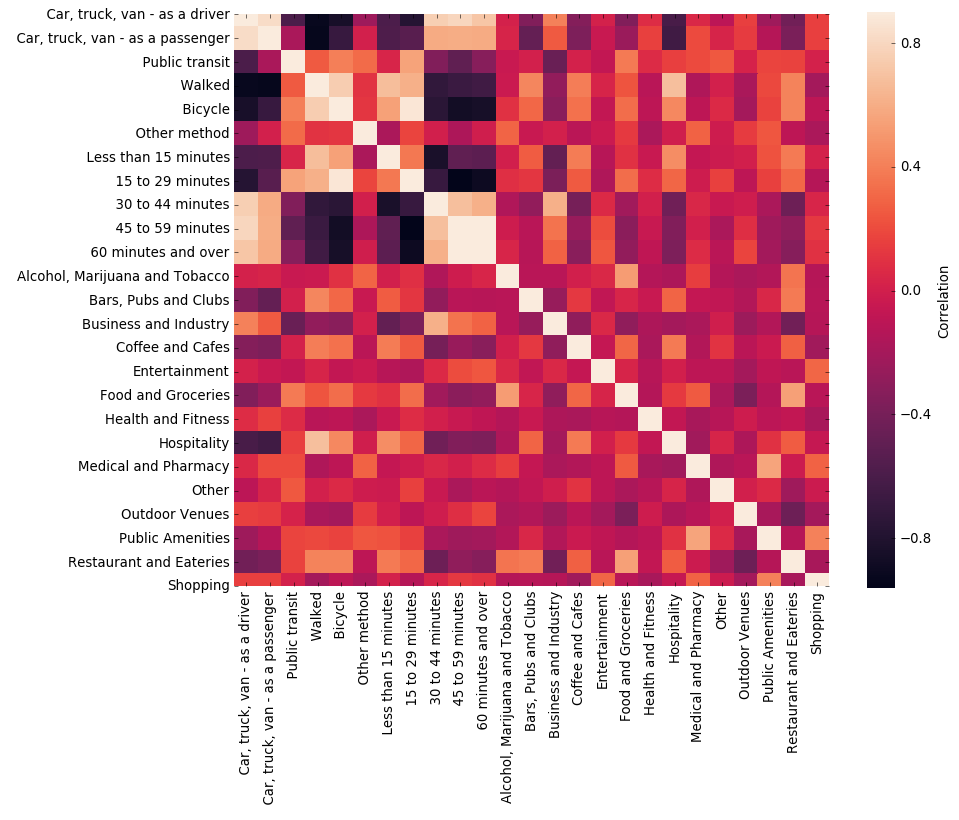

In [84]:
# Plot the Correlation map to see how features are correlated with target: SalePrice
corr_matrix = df_learning_numerical.corr()
plt.subplots(figsize=(12,9), facecolor = 'w')
sns.heatmap(corr_matrix, vmax=0.9, square=True, cbar_kws = {'label':'Correlation'})
plt.savefig('all_data_heatmap.png')

There are some interesting correlations here. For example, There is a strong correlation between people who walk to work and hospitality venues nearby. There is also a strong correlation between commutes of 30-44 minutes and business and industry services nearby. There are also plenty of food and groceries in the same areas as there are restaurants and eateries.

### Exploring venue data within wards

Let's look at the prevalence of restaurants in the wards:

In [85]:
df_ward_venues = df_learning_merged.groupby('Ward ID').mean().reset_index()

Let's look at the prevalence of restaurants and eateries as venues in each ward:

In [86]:
map_ottawa1 = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# Now let's make our Choropleth:
map_ottawa1.choropleth(
    geo_data = geojson_data,
    data = df_ward_venues,
    columns = ['Ward ID', 'Restaurant and Eateries'],
    key_on = 'feature.properties.WARD_NUM',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Prevalence of Restaurants and Eateries')

# Iterate through generated lists and add polygons plus labels to the map
style1 = {'color':'#330000'}
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_ottawa1)

# Display our choropleth map:
map_ottawa1.save('restaurants.html')
map_ottawa1

Downtown wards have plenty of restaurants and eateries, but also Orleans and Barrhaven boast large numbers too!

Now venues for shopping:

In [102]:
map_ottawa1 = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# Now let's make our Choropleth:
map_ottawa1.choropleth(
    geo_data = geojson_data,
    data = df_ward_venues,
    columns = ['Ward ID', 'Shopping'],
    key_on = 'feature.properties.WARD_NUM',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Prevalence of Shopping Venues')

# Iterate through generated lists and add polygons plus labels to the map
style1 = {'color':'#330000'}
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_ottawa1)

# Display our choropleth map:
map_ottawa1.save('shopping.html')
map_ottawa1

There seems to be a higher proportion of shopping in suburban neighborhoods than there is in downtown neighborhoods.

What about coffee and cafes?

In [103]:
map_ottawa1 = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# Now let's make our Choropleth:
map_ottawa1.choropleth(
    geo_data = geojson_data,
    data = df_ward_venues,
    columns = ['Ward ID', 'Coffee and Cafes'],
    key_on = 'feature.properties.WARD_NUM',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = 'Prevalence of Coffee Shops and Cafes')

# Iterate through generated lists and add polygons plus labels to the map
style1 = {'color':'#330000'}
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_ottawa1)

# Display our choropleth map:
map_ottawa1.save('coffee.html')
map_ottawa1

There is a large proportion of coffee shops found right downtown, and also in Stittsville.

Let's look at all the venue categories divided between wards:

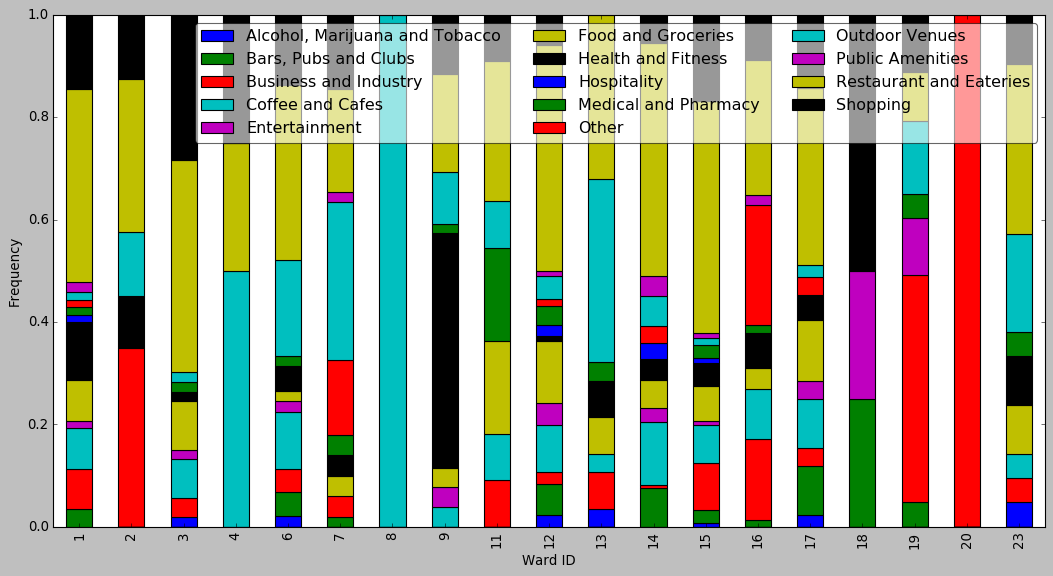

In [89]:
# Sort a dataframe by ward number:
df = df_ward_venues.copy()
df['Ward ID'] = df['Ward ID'].astype(int)
df.sort_values(['Ward ID'], inplace = True)
df.dropna(inplace = True)
df.reset_index(inplace = True)
df.drop(['index'], axis = 1, inplace = True)
df.drop(df.columns[1:14].values, axis = 1, inplace = True)
df.set_index('Ward ID', inplace = True)

# Plot:
df.plot(kind = 'bar', stacked = True, figsize = (16, 8))
plt.xlabel('Ward ID')
plt.ylabel('Frequency')
plt.style.use('classic')
plt.legend(ncol = 3, fancybox = True, framealpha = 0.6)
plt.savefig('venue_barchart.png')

### Hyperparameter optimization

It is good practice to normalize our data before performing machine learning. Thus, let us do this first:

In [90]:
from sklearn import preprocessing

X = preprocessing.StandardScaler().fit(df_learning_numerical).transform(df_learning_numerical)

Finally, let's perform K-Means clustering. For K-Means, the value of k should be calculated using the elbow method. As such, we will calculate distortion for a range of k values:

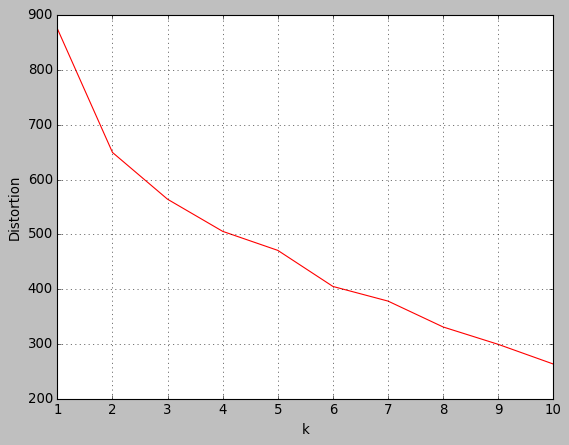

In [91]:
# Import modules:
from sklearn.cluster import KMeans

# Calculate distortion for a bunch of k's:
kmax = 10
distortions = []
for i in range(1, kmax + 1):
    km = KMeans(n_clusters = i, random_state = 0, init = "k-means++", n_init = 12).fit(X)
    distortions.append(km.inertia_)

# Plot values:
plt.plot(range(1, kmax + 1), distortions, color = 'red')
plt.grid()
plt.xlabel('k')
plt.ylabel('Distortion')
plt.savefig('kmeans_opt.png')

There is not an extremely clear elbow point on this plot. However, the change in distortion does deflect to a great degree at k = 5. While this may contribute to some ambiguous clustering, the return on reduction in distortion with increasing k is diminishing past this point.

In [92]:
# Set number of clusters
k = 5

# Run K-Means clustering:
kmeans = KMeans(n_clusters = k, random_state = 0, init = "k-means++", n_init = 12).fit(X)

# Check cluster labels:
kmeans.labels_[:]

array([0, 4, 2, 2, 4, 3, 2, 4, 2, 2, 4, 4, 4, 1, 4, 2, 4, 4, 2, 1, 2, 0,
       0, 0, 0, 1, 4, 2, 2, 1, 2, 2, 3, 4, 4])

Let's try DBSCAN now. For DBSCAN, the value of epsilon should be calculated using the elbow method. As such, we will calculate the distance of each point to its nearest neighbor:

In [93]:
# Import modules:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

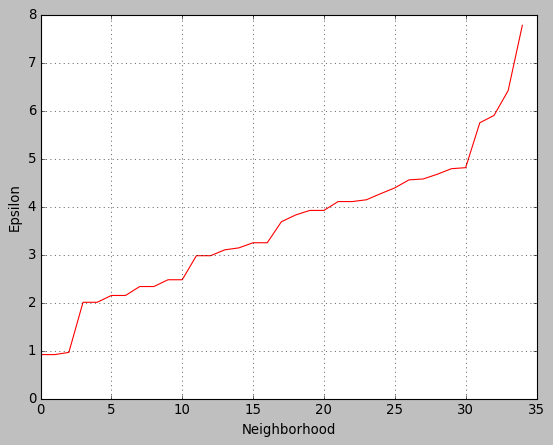

In [94]:
# Calculate distances:
neigh = NearestNeighbors(n_neighbors = 2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# Plot value:
distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.plot(distances, color = 'red')
plt.grid()
plt.xlabel('Neighborhood')
plt.ylabel('Epsilon')
plt.savefig('db_opt.png')

From this, it could be argued that a value of Epsilon of 5.2 is ideal. We will consider a cluster to be a group that has at least 2 neighborhoods in it.

In [95]:
# Run DBSCAN clustering:
db = DBSCAN(eps = 5.2, min_samples = 2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
core_samples_mask[db.core_sample_indices_] = True
db.labels_[:]

array([ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0], dtype=int64)

Excellent! Now let's create a final dataframe:

In [96]:
# Add a clustering labels:
neighborhoods_venues_sorted.insert(0, 'K-Means Label', kmeans.labels_)
neighborhoods_venues_sorted.insert(0, 'DBSCAN Label', db.labels_)

# Merge two dataframes together:
df_ottawa_clustered = df_ottawa.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on = 'Neighborhood')

df_ottawa_clustered

Postal Code                                       Neighborhood  Latitude  \
0          K1A  Government of Canada: Ottawa and Gatineau offi...   45.4207   
1          K2A  Highland Park / McKellar Park  Westboro  Glaba...   45.3805   
2          K4A                                       Fallingbrook   45.4697   
3          K1B      Blackburn Hamlet / Pine View / Sheffield Glen   45.4284   
4          K2B       Britannia  Whitehaven / Bayshore / Pinecrest   45.3645   
5          K4B                                              Navan   45.4101   
6          K1C                                            Orleans   45.4677   
7          K2C  Queensway / Copeland Park / Central Park / Bel...   45.3679   
8          K4C                                         Cumberland   45.4980   
9          K1E                                         Queenswood   45.4771   
10         K2E  Eastern Nepean: Fisher Height / Parkwood Hills...   45.3438   
11         K1G  Riverview / Hawthorne / Canterbury / Hunt Club...   45.3548   
12         K2G  Centrepointe / Meadowlands / City View / Craig...   45.3211   
13         K1H                       Alta Vista / Billings Bridge   45.3876   
14         K2H  Bells Corners / Arlington Wood / Redwood / Qua...   45.3433   
15         K1J              Beacon Hill / Cyrville / Carson Grove   45.4519   
16         K2J                                          Barrhaven   45.2691   
17         K1K  Overbrook / Forbes / Manor Park / Viscount Ale...   45.4448   
18         K2K                          Beaverbrook / South March   45.3704   
19         K1L                           Vanier / McKay Lake area   45.4400   
20         K2L                   Katimavik-Hazeldean / Glen Cairn   45.3001   
21         K1M                    Rockcliffe Park / New Edinburgh   45.4491   
22         K2M                                         Bridlewood   45.2861   
23         K4M                                           Manotick   45.2154   
24         K1N  Lower Town / Byward Market / Sandy Hill / Univ...   45.4289   
25         K1P                                           Downtown   45.4225   
26         K2P                                         Centretown   45.4166   
27         K4P                                             Greely   45.2434   
28         K1R                                     Dalhousie Ward   45.4123   
29         K2R  Fallowfield Village / Cedarhill Estates / Orch...   45.2899   
30         K1S  The Glebe / Old Ottawa South / Old Ottawa East...   45.3990   
31         K2S                                        Stittsville   45.2501   
32         K1T  Blossom Park / Greenboro / Leitrim / Findlay C...   45.3295   
33         K2T                                          Marchwood   45.3170   
34         K1V  Heron Gate / Heron Park / Riverside Park / Hun...   45.3281   
35         K2V                              Terry Fox / Palladium   45.2854   
36         K1W                      Chapel Hill South / Blackburn   45.4365   
37         K2W                                        North March   45.3699   
38         K1X                                   South Gloucester   45.2756   
39         K1Y  Civic Hospital / Island Park / Hintonburg / Me...   45.4023   
40         K1Z                              Westboro / Carlington   45.3867   

    Longitude                  Ward Ward ID    Car, truck, van - as a driver  \
0    -75.7023              Somerset      14                         0.246610   
1    -75.7636          Kitchissippi      15                         0.489164   
2    -75.4715            Cumberland      19                         0.711613   
3    -75.5875                 Innes       2                         0.681313   
4    -75.7934                   Bay       7                         0.545987   
5    -75.3638            Cumberland      19                         0.711613   
6    -75.5399               Orléans       1                         0.653115   
7    -75.7381                 River      16 

Note that the DBSCAN labels of -1 indicate an outlier. Labels of NaN indicate that venue data was insufficient.

Let's visualize the K-Means cluster labels on a map of Ottawa:

In [97]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

# Create a map of Ottawa using coordinates:
map_kmeans = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# A color schematic that's pleasant on the eyes:
style1 = {'fillColor': '#D4F7B9', 'color':'#377805'}

# Draw Wards:
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_kmeans)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_ottawa_clustered['Latitude'], df_ottawa_clustered['Longitude'], \
                                  df_ottawa_clustered['Neighborhood'], df_ottawa_clustered['K-Means Label']):
    if math.isnan(cluster) == False:
        label = folium.Popup(str(poi) + ' (Cluster ' + str(int(cluster)) + ')', parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_kmeans)

map_kmeans.save('kmeans_plot.html')
map_kmeans

And now let's visualize DBSCAN labels on a map:

In [98]:
# Create a map of Ottawa using coordinates:
map_db = folium.Map(location = [latitude_ottawa, longitude_ottawa], zoom_start = 10, tiles = 'Stamen Toner')

# A color schematic that's pleasant on the eyes:
style1 = {'fillColor': '#D4F7B9', 'color':'#377805'}

# Draw Wards:
for i in range(0, len(ward_name)):
    gj = folium.GeoJson(data = {'type':'Polygon', 'coordinates':ward_polygon[i]}, style_function = lambda x: style1)
    gj.add_child(folium.Popup('{} (Ward {})'.format(ward_name[i], ward_number[i])))
    gj.add_to(map_db)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_ottawa_clustered['Latitude'], df_ottawa_clustered['Longitude'], \
                                  df_ottawa_clustered['Neighborhood'], df_ottawa_clustered['DBSCAN Label']):
    if math.isnan(cluster) == False:
        label = folium.Popup(str(poi) + ' (Cluster ' + str(int(cluster)) + ')', parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster)-1],
            fill=True,
            fill_color=rainbow[int(cluster)-1],
            fill_opacity=0.7).add_to(map_db)

map_db.save('db_plot.html')
map_db

### Making tables more digestible

While we do have all our data, the table is quite large and does not look visually appealing. Let's modify it so that it is easier to visually scan and can be exported seamlessly.

In [99]:
# Determine Most Common Mode of Commuting:
mode = []
mode_options = ['Driving', 'Driving (Passenger)', 'Public Transit', 'Walking', 'Biking', 'Other']
for position, row in enumerate(df_ottawa_clustered.iterrows()):
    temps = []
    for i in range(6, 12):
        temps.append(df_ottawa_clustered.iloc[position, i])
    mode.append(mode_options[temps.index(max(temps))])
    
# Determine Most Common Commute Time:
time = []
time_options = ['< 15', '15 - 29', '30 - 44', '45 - 59', '> 60']
for position, row in enumerate(df_ottawa_clustered.iterrows()):
    temps = []
    for i in range(12, 17):
        temps.append(df_ottawa_clustered.iloc[position, i])
    time.append(time_options[temps.index(max(temps))])

# Add columns to dataframe:
df_ottawa_clustered['Most Common Commuting Mode'] = mode
df_ottawa_clustered['Most Common Commuting Time'] = time

# Drop some columns:
df_output = df_ottawa_clustered.drop(['Latitude', 'Longitude', 'Ward ID', 'Postal Code', '4th Most Common Venue', \
                                      '5th Most Common Venue', '6th Most Common Venue', '7th Most Common Venue', \
                                      '8th Most Common Venue', '9th Most Common Venue', '10th Most Common Venue', \
                                     '  Car, truck, van - as a passenger', '  Car, truck, van - as a driver', \
                                     '  Public transit', '  Walked', '  Bicycle', '  Other method', '  Less than 15 minutes', \
                                     '  15 to 29 minutes', '  30 to 44 minutes', '  45 to 59 minutes', \
                                      '  60 minutes and over'], axis = 1)
df_output.head()

Neighborhood          Ward  \
0  Government of Canada: Ottawa and Gatineau offi...      Somerset   
1  Highland Park / McKellar Park  Westboro  Glaba...  Kitchissippi   
2                                       Fallingbrook    Cumberland   
3      Blackburn Hamlet / Pine View / Sheffield Glen         Innes   
4       Britannia  Whitehaven / Bayshore / Pinecrest           Bay   

   DBSCAN Label  K-Means Label    1st Most Common Venue  \
0           0.0            4.0  Restaurant and Eateries   
1           0.0            1.0  Restaurant and Eateries   
2           0.0            2.0           Outdoor Venues   
3           0.0            4.0  Restaurant and Eateries   
4           0.0            2.0  Restaurant and Eateries   

     2nd Most Common Venue  3rd Most Common Venue Most Common Commuting Mode  \
0         Coffee and Cafes         Outdoor Venues                    Walking   
1                 Shopping     Health and Fitness                    Driving   
2  Restaurant and Eateries   Medical and Pharmacy                    Driving   
3       Health and Fitness  Business and Industry                    Driving   
4           Outdoor Venues   Medical and Pharmacy                    Driving   

  Most Common Commuting Time  
0                    15 - 29  
1                    15 - 29  
2                    15 - 29  
3                    15 - 29  
4                    15 - 29

Now let's export our data:

In [100]:
df_output.to_csv(r'clustered_data.csv', index = False)